### IMPORT LIBRARIES

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import requests # library to handle requests

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!conda install -c conda-forge geocoder --yes
import geocoder  

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


### DATA COLLECTION

#### COVID DATA OF NYC (https://www1.nyc.gov/site/doh/covid/covid-19-data.page)

In [2]:
c_data = pd.read_csv('covid_data_nyc.csv').drop(['Unnamed: 0'],axis=1)
c_data.head()

,ZIP,Neighborhood,Borough,Total cases (4 weeks)
0,10002,Chinatown/Lower East Side,Manhattan,72
1,10003,East Village/Gramercy/Greenwich Village,Manhattan,19
2,10004,Financial District,Manhattan,1
3,10005,Financial District,Manhattan,8
4,10006,Financial District,Manhattan,2


In [3]:
# group same neighborhood to get total cases in each neighborhood in past 4 weeks
c_data = c_data.drop(['ZIP'],axis=1)
c_data = c_data.groupby(['Neighborhood','Borough']).sum().reset_index()
c_data.head()

,Neighborhood,Borough,Total cases (4 weeks)
0,Airport/South Jamaica/Springfield Gardens/St. ...,Queens,28
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,55
2,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,99
3,Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,31
4,Arrochar/Midland Beach/Shore Acres/South Beach...,Staten Island,38


In [4]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Neighborhood           122 non-null    object
 1   Borough                122 non-null    object
 2   Total cases (4 weeks)  122 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.0+ KB


#### COORDINATES OF NEIGHBORHOODS FROM GEOCODER

In [5]:
# Defining a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, New York, US'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in c_data["Neighborhood"].tolist()]

In [6]:
# Create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
# Merge the coordinates into the original dataframe
c_data['Latitude'] = df_coords['Latitude']
c_data['Longitude'] = df_coords['Longitude']

In [7]:
c_data.head()

,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude
0,Airport/South Jamaica/Springfield Gardens/St. ...,Queens,28,40.667350,-73.776709
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,55,40.863930,-73.843390
2,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,99,40.857969,-73.851246
3,Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,31,40.732440,-73.977710
4,Arrochar/Midland Beach/Shore Acres/South Beach...,Staten Island,38,40.609550,-74.066170


In [8]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighborhood           122 non-null    object 
 1   Borough                122 non-null    object 
 2   Total cases (4 weeks)  122 non-null    int64  
 3   Latitude               122 non-null    float64
 4   Longitude              122 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.9+ KB


In [48]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

#### HOSPITAL DATA FROM FOURSQUARE

In [49]:
# @hidden_cell
CLIENT_ID = '*******' # your Foursquare ID
CLIENT_SECRET = '********' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [11]:
c_id = '4bf58dd8d48988d196941735' #hospital id - 4bf58dd8d48988d196941735
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            c_id,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Name', 
                  'Category']
    
    return(nearby_venues)

In [12]:
h_data = getNearbyVenues(names=c_data['Neighborhood'],
                                   latitudes=c_data['Latitude'],
                                   longitudes=c_data['Longitude'])

Airport/South Jamaica/Springfield Gardens/St. Albans
Allerton/Baychester/Pelham Gardens/Williamsbridge
Allerton/Norwood/Pelham Parkway/Williamsbridge
Alphabet City/East Village/Stuyvesant Town-Cooper Village
Arrochar/Midland Beach/Shore Acres/South Beach Ocean Breeze
Arverne/Edgemere
Astoria (North)/Astoria (South)
Astoria (South)
Astoria (South)/Long Island City/Sunnyside
Auburndale/Fresh Meadows/Pomonok/Utopia
Auburndale/Murray Hill
Bath Beach/Bensonhurst/Gravesend
Bath Beach/Dyker Heights
Battery Park City
Bay Ridge/Fort Hamilton
Bayside (North)/Bayside (South)
Bayside (South)/Oakland Gardens
Bedford-Stuyvesant (East)/Bushwick
Bedford-Stuyvesant (East)/Ocean Hill-Brownsville
Bedford-Stuyvesant (West)/Clinton Hill/Fort Greene
Bedford-Stuyvesant (West)/Crown Heights (West)
Belmont/Fordham University/Kingsbridge
Bensonhurst/Mapleton
Bergen Beach/Flatlands/Marine Park/Mill Basin
Boerum Hill/Park Slope
Borough Park
Briarwood/Jamaica
Brighton Beach/Coney Island/Seagate
Brighton Beach/Manh

In [13]:
h_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Name,Category
0,Airport/South Jamaica/Springfield Gardens/St. ...,40.66735,-73.776709,"Dr. Sandip Parikh, MD",Hospital
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,40.86393,-73.843390,"Talha Shaikh, MD",Hospital
2,Allerton/Baychester/Pelham Gardens/Williamsbridge,40.86393,-73.843390,Dr. Prachi Jain,Hospital
3,Allerton/Baychester/Pelham Gardens/Williamsbridge,40.86393,-73.843390,"Angela M. Godwin, Nurse Practitioner in Family...",Hospital
4,Allerton/Baychester/Pelham Gardens/Williamsbridge,40.86393,-73.843390,Metro UrgiCare,Hospital


In [14]:
h_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            1171 non-null   object 
 1   Neighborhood Latitude   1171 non-null   float64
 2   Neighborhood Longitude  1171 non-null   float64
 3   Name                    1171 non-null   object 
 4   Category                1171 non-null   object 
dtypes: float64(2), object(3)
memory usage: 45.9+ KB


In [15]:
h_data.Category.unique()

array(['Hospital', "Doctor's Office", 'Eye Doctor', 'Hospital Ward',
       'Pet Service', 'Veterinarian', 'Emergency Room', 'Coworking Space',
       'Mental Health Office', 'Medical Center', 'Medical School',
       'College Science Building', 'Pharmacy', "Dentist's Office",
       'Building', 'IT Services', 'Office', 'Police Station',
       'Medical Supply Store'], dtype=object)

In [16]:
h_data = h_data[h_data.Category == 'Hospital']
h_data.to_csv('NYC_hospital.csv')

In [17]:
h_data = pd.read_csv('NYC_hospital.csv')
h_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              986 non-null    int64  
 1   Neighborhood            986 non-null    object 
 2   Neighborhood Latitude   986 non-null    float64
 3   Neighborhood Longitude  986 non-null    float64
 4   Name                    986 non-null    object 
 5   Category                986 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 46.3+ KB


#### CONVERT INTO DUMMIES AND COUNT NUMBER OF HOSPITALS IN EACH NEIGHBORHOOD (WITHIN 1KM)

In [18]:
d = pd.get_dummies(h_data['Name'])
d['Neighborhood'] = h_data['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [d.columns[-1]] + list(d.columns[:-1])
d = d[fixed_columns]

d.head()

,Neighborhood,1000 10th Avenue,11 West Private Accommodations Mount Sinai Medica Center,11th Floor MRI MSKCC,205 East 64th Street - MSKCC,301 e. 55th st,4North 4South,7 Uris,9B Lincoln Hospital,9GS 325-2,...,Welcare Hospital Beds,Westchester Square Medical Center,"Williamsburg Pharmacy & Surgical Supply, Inc",Woodside Optical,XXI CENTURY RADIOLOGY,abortionpillnyc.com,department of nephrology NY Presbyterian,dr martin luther king jr health center,lennox hill hospital,mskcc surgery 6 floor
0,Airport/South Jamaica/Springfield Gardens/St. ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Allerton/Baychester/Pelham Gardens/Williamsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Allerton/Baychester/Pelham Gardens/Williamsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allerton/Baychester/Pelham Gardens/Williamsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
d = d.groupby('Neighborhood').sum().reset_index()
e = d.sum(axis=1)
d['No. of Hospitals'] = e
d.head()

,Neighborhood,1000 10th Avenue,11 West Private Accommodations Mount Sinai Medica Center,11th Floor MRI MSKCC,205 East 64th Street - MSKCC,301 e. 55th st,4North 4South,7 Uris,9B Lincoln Hospital,9GS 325-2,...,Westchester Square Medical Center,"Williamsburg Pharmacy & Surgical Supply, Inc",Woodside Optical,XXI CENTURY RADIOLOGY,abortionpillnyc.com,department of nephrology NY Presbyterian,dr martin luther king jr health center,lennox hill hospital,mskcc surgery 6 floor,No. of Hospitals
0,Airport/South Jamaica/Springfield Gardens/St. ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,Allerton/Norwood/Pelham Parkway/Williamsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,Alphabet City/East Village/Stuyvesant Town-Coo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,48
4,Arrochar/Midland Beach/Shore Acres/South Beach...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
d = d[['Neighborhood','No. of Hospitals']]
d.head()

,Neighborhood,No. of Hospitals
0,Airport/South Jamaica/Springfield Gardens/St. ...,1
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,7
2,Allerton/Norwood/Pelham Parkway/Williamsbridge,8
3,Alphabet City/East Village/Stuyvesant Town-Coo...,48
4,Arrochar/Midland Beach/Shore Acres/South Beach...,1


In [21]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Neighborhood      122 non-null    object
 1   No. of Hospitals  122 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


#### COMBINE COVID & HOSPITAL DATASETS

In [22]:
data = pd.merge(c_data,d,on=['Neighborhood'],how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 0 to 121
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighborhood           122 non-null    object 
 1   Borough                122 non-null    object 
 2   Total cases (4 weeks)  122 non-null    int64  
 3   Latitude               122 non-null    float64
 4   Longitude              122 non-null    float64
 5   No. of Hospitals       122 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 6.7+ KB


In [23]:
data.head()

,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude,No. of Hospitals
0,Airport/South Jamaica/Springfield Gardens/St. ...,Queens,28,40.667350,-73.776709,1
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,55,40.863930,-73.843390,7
2,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,99,40.857969,-73.851246,8
3,Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,31,40.732440,-73.977710,48
4,Arrochar/Midland Beach/Shore Acres/South Beach...,Staten Island,38,40.609550,-74.066170,1


In [24]:
# save data set locally
data.to_csv('NYC.csv')

In [61]:
import pandas as pd
data = pd.read_csv('NYC.csv').drop(['Unnamed: 0'],axis=1)
data.head()

,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude,No. of Hospitals
0,Airport/South Jamaica/Springfield Gardens/St. ...,Queens,28,40.667350,-73.776709,1
1,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,55,40.863930,-73.843390,7
2,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,99,40.857969,-73.851246,8
3,Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,31,40.732440,-73.977710,48
4,Arrochar/Midland Beach/Shore Acres/South Beach...,Staten Island,38,40.609550,-74.066170,1


### EDA

In [26]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

Text(0.5, 1.0, 'Queens')

<Figure size 1800x1080 with 0 Axes>

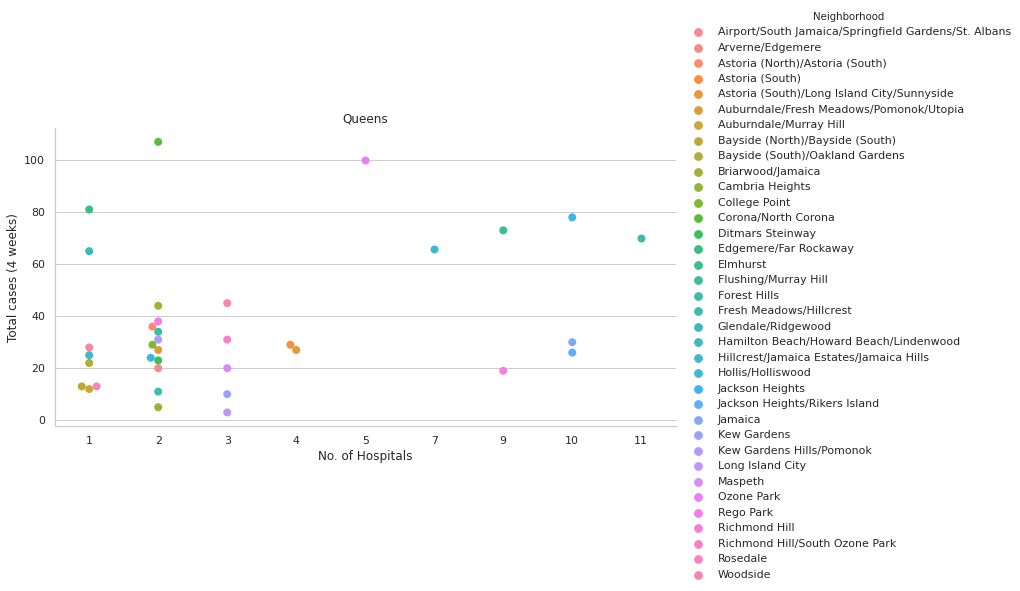

In [27]:
plt.figure(figsize=(25,15))
sns.set(style="whitegrid")
sns.catplot(y='Total cases (4 weeks)', x='No. of Hospitals', data=data[data['Borough']=='Queens'], hue='Neighborhood', kind='swarm',height=5, aspect=2,s=8,legend='Neighborhood') 
plt.title('Queens')

Text(0.5, 1.0, 'Bronx')

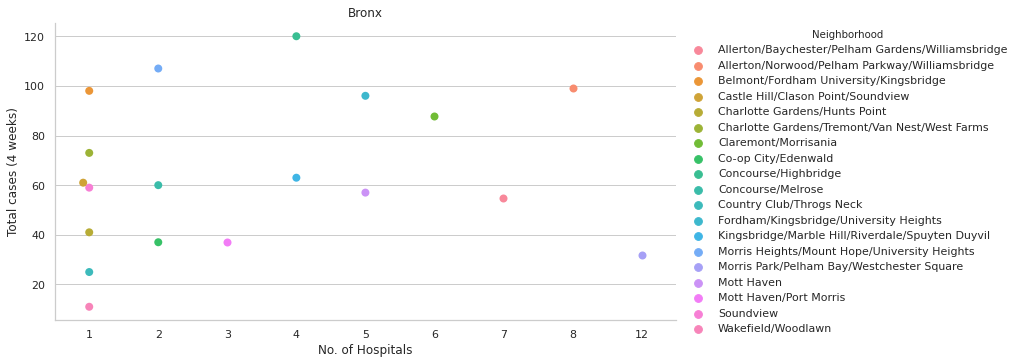

In [28]:
sns.set(style="whitegrid")
sns.catplot(y='Total cases (4 weeks)', x='No. of Hospitals', data=data[data['Borough']=='Bronx'], hue='Neighborhood', kind='swarm',height=5, aspect=2,s=8,legend='Neighborhood') 
plt.title('Bronx')

Text(0.5, 1.0, 'Manhattan')

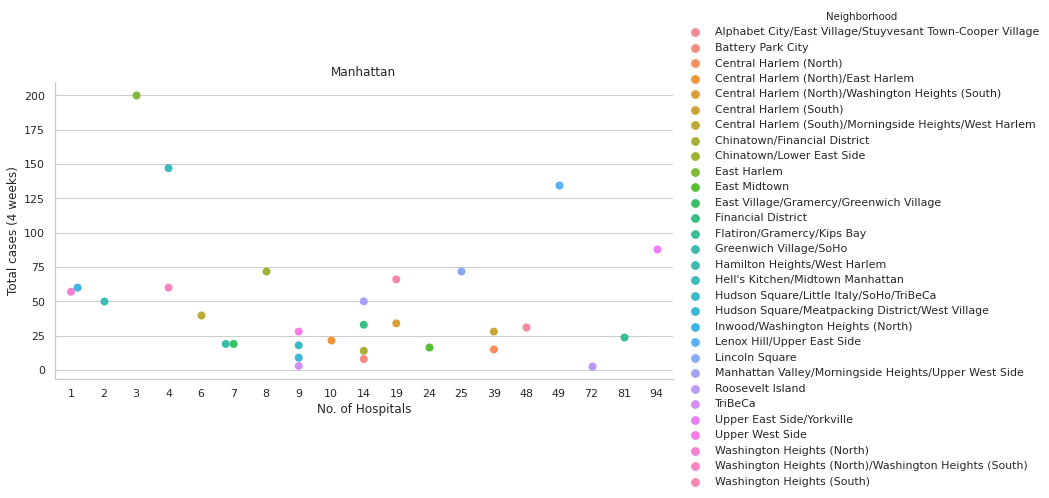

In [29]:
sns.set(style="whitegrid")
sns.catplot(y='Total cases (4 weeks)', x='No. of Hospitals', data=data[data['Borough']=='Manhattan'], hue='Neighborhood', kind='swarm',height=5, aspect=2,s=8,legend='Neighborhood') 
plt.title('Manhattan')

Text(0.5, 1.0, 'Brooklyn')

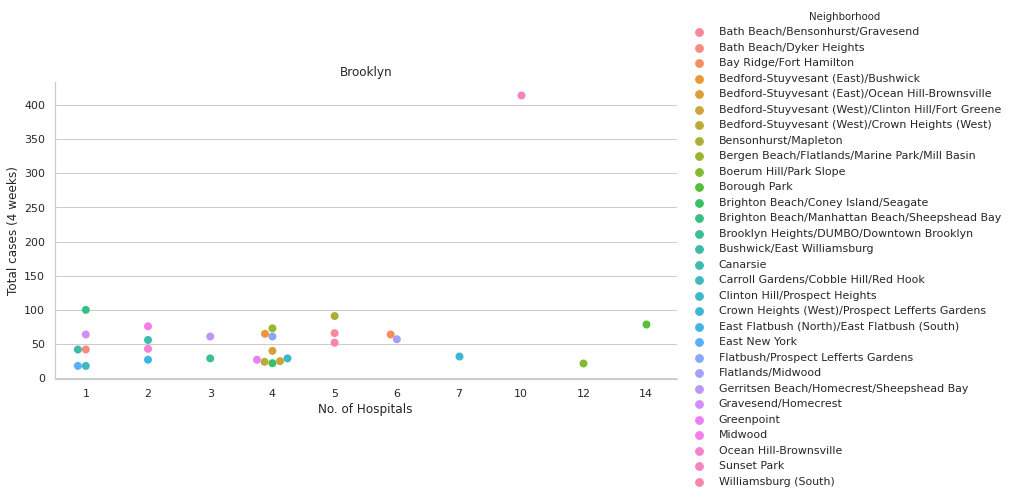

In [30]:
sns.set(style="whitegrid")
sns.catplot(y='Total cases (4 weeks)', x='No. of Hospitals', data=data[data['Borough']=='Brooklyn'], hue='Neighborhood', kind='swarm',height=5, aspect=2,s=8,legend='Neighborhood') 
plt.title('Brooklyn')

Text(0.5, 1.0, 'Staten Island')

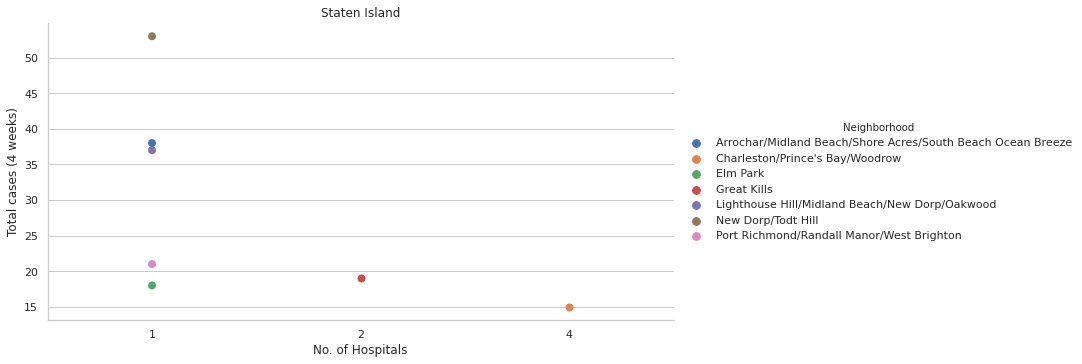

In [31]:
sns.set(style="whitegrid")
sns.catplot(y='Total cases (4 weeks)', x='No. of Hospitals', data=data[data['Borough']=='Staten Island'], hue='Neighborhood', kind='swarm',height=5, aspect=2,s=8,legend='Neighborhood') 
plt.title('Staten Island')

In [33]:
import numpy as np
hos = data.groupby('Borough')[['No. of Hospitals','Total cases (4 weeks)']].sum()
hos = hos.sort_values('No. of Hospitals').reset_index()
hos

,Borough,No. of Hospitals,Total cases (4 weeks)
0,Staten Island,11,201
1,Bronx,67,1219
2,Brooklyn,126,1820
3,Queens,128,1315
4,Manhattan,654,1422


Text(0, 0.5, 'Total cases (4 weeks)')

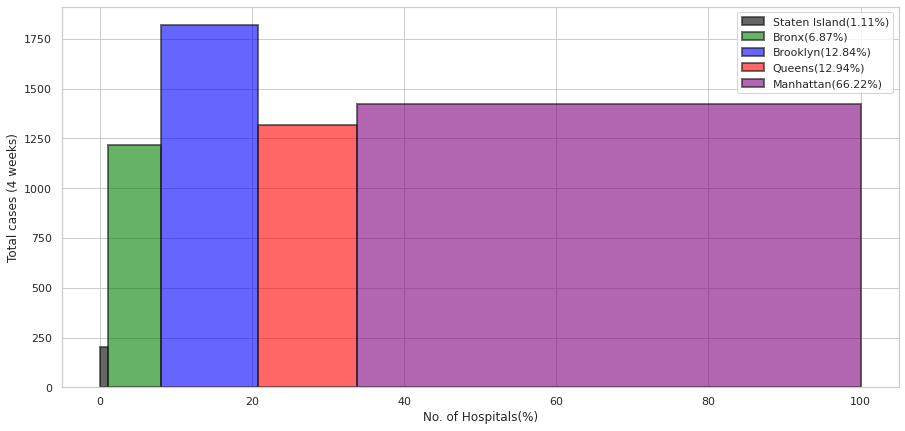

In [34]:
import seaborn as sns
widths = [1.112,6.875,12.841,12.942,66.228] # % of no of hospitals in nyc in each borough
cols=('black','green','blue','red','purple')
label=['Staten Island(1.11%)','Bronx(6.87%)','Brooklyn(12.84%)','Queens(12.94%)','Manhattan(66.22%)']
x = [0,1.112,1.112+6.875,1.112+6.875+12.841,1.112+6.875+12.841+12.942]
plt.figure(figsize=(15,7))
ax = plt.bar(x, hos['Total cases (4 weeks)'], width = widths, color=cols, 
alpha = 0.6, align='edge', edgecolor = 'k', linewidth = 2,label=label)
plt.legend(handles=ax, labels=label)
plt.xlabel('No. of Hospitals(%)')
plt.ylabel('Total cases (4 weeks)')

### CLUSTERING USING K-MEANS

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.cluster import KMeans

In [62]:
# Cleaning data for k-means
df_clusters = data.drop(['Borough', 'Neighborhood', 'Latitude', 'Longitude'],axis = 1)
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Total cases (4 weeks)  122 non-null    int64
 1   No. of Hospitals       122 non-null    int64
dtypes: int64(2)
memory usage: 2.0 KB


In [63]:
# Normalizing data
df_clusters = sklearn.preprocessing.StandardScaler().fit_transform(df_clusters)
df_clusters

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-4.52316682e-01, -4.87209920e-01],
       [ 1.29460417e-01, -7.44348489e-02],
       [ 1.07754162e+00, -5.63900370e-03],
       [-3.87674782e-01,  2.74619480e+00],
       [-2.36843683e-01, -4.87209920e-01],
       [-6.24695082e-01, -4.18414075e-01],
       [-2.79938283e-01, -4.18414075e-01],
       [-4.30769382e-01, -2.80822384e-01],
       [-4.73863982e-01, -2.80822384e-01],
       [-4.73863982e-01, -4.18414075e-01],
       [-7.97073482e-01, -4.87209920e-01],
       [ 3.66480717e-01, -2.12026539e-01],
       [-1.50654483e-01, -4.87209920e-01],
       [-8.83262682e-01,  4.07136067e-01],
       [ 3.23386117e-01, -1.43230694e-01],
       [-7.75526182e-01, -4.87209920e-01],
       [-5.81600482e-01, -4.87209920e-01],
       [ 3.44933417e-01, -2.80822384e-01],
       [-1.93749083e-01, -2.80822384e-01],
       [-5.16958582e-01, -2.80822384e-01],
       [-5.38505882e-01, -2.80822384e-01],
       [ 1.05599432e+00, -4.87209920e-01],
       [ 9.05163216e-01, -2.12026539e-01],
       [ 5.

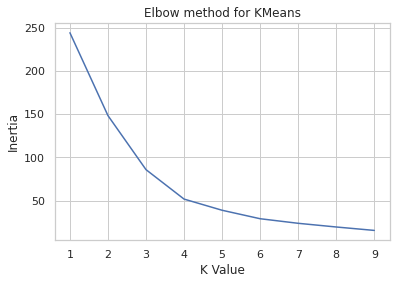

In [64]:
# use elbow method to identify the optimal number of clusters
sum_squared_distance=[]

for k in range(1,10):
    kmeans=KMeans(n_clusters=k).fit(df_clusters)
    kmeans.predict(df_clusters)
    sum_squared_distance.append(kmeans.inertia_)

#Let's plot the graph now to find the optimal 'k'

plt.plot(range(1,10),sum_squared_distance)
plt.title("Elbow method for KMeans")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.show()

In [65]:
#use kmeans to cluster
kclusters = 3
kmeans=KMeans(n_clusters=kclusters).fit(df_clusters)
kmeans.predict(df_clusters)
data.insert(0,'Cluster_label',kmeans.labels_)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cluster_label          122 non-null    int32  
 1   Neighborhood           122 non-null    object 
 2   Borough                122 non-null    object 
 3   Total cases (4 weeks)  122 non-null    int64  
 4   Latitude               122 non-null    float64
 5   Longitude              122 non-null    float64
 6   No. of Hospitals       122 non-null    int64  
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 6.3+ KB


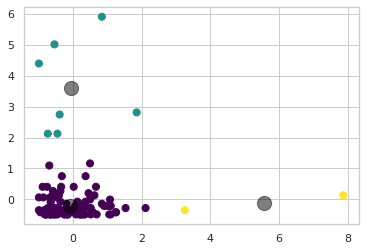

In [66]:
# set number of clusters
kclusters = 3
kmeans = KMeans(n_clusters=kclusters)
kmeans.fit(df_clusters)
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [80]:
cluster = data[data['Cluster_label']==2]
cluster

,Cluster_label,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude,No. of Hospitals
56,2,East Harlem,Manhattan,200,40.79828,-73.94081,3
112,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10


In [68]:
data[data['Cluster_label']==1]

,Cluster_label,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude,No. of Hospitals
0,1,Airport/South Jamaica/Springfield Gardens/St. ...,Queens,28,40.667350,-73.776709,1
1,1,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,55,40.863930,-73.843390,7
2,1,Allerton/Norwood/Pelham Parkway/Williamsbridge,Bronx,99,40.857969,-73.851246,8
4,1,Arrochar/Midland Beach/Shore Acres/South Beach...,Staten Island,38,40.609550,-74.066170,1
5,1,Arverne/Edgemere,Queens,20,40.592499,-73.786707,2
...,...,...,...,...,...,...,...
117,1,Washington Heights (North),Manhattan,57,40.855460,-73.933790,1
118,1,Washington Heights (North)/Washington Heights ...,Manhattan,60,40.847572,-73.929658,4
119,1,Washington Heights (South),Manhattan,66,40.842310,-73.939240,19
120,1,Williamsburg (South),Brooklyn,52,40.712923,-73.969560,5


In [78]:
data[data['Cluster_label']==0]


,Cluster_label,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude,No. of Hospitals
3,0,Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,31,40.732440,-73.977710,48
35,0,Central Harlem (North),Manhattan,15,40.798756,-73.953668,39
38,0,Central Harlem (South),Manhattan,28,40.798756,-73.953668,39
65,0,Flatiron/Gramercy/Kips Bay,Manhattan,24,40.739550,-73.977080,81
91,0,Lenox Hill/Upper East Side,Manhattan,135,40.773770,-73.959600,49
109,0,Roosevelt Island,Manhattan,3,40.764560,-73.947320,72
114,0,Upper East Side/Yorkville,Manhattan,88,40.770620,-73.957030,94


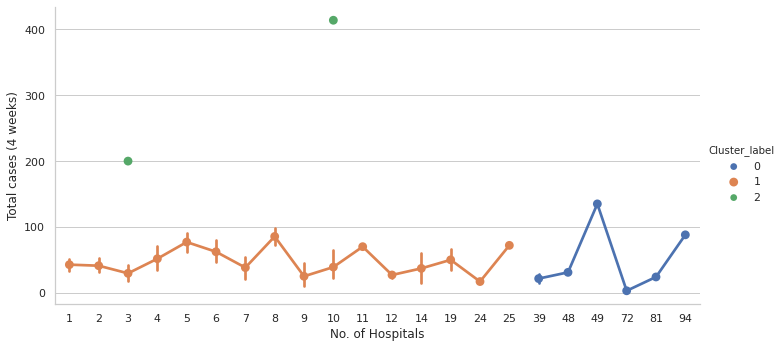

In [70]:
sns.catplot(y='Total cases (4 weeks)', x='No. of Hospitals', data=data, hue='Cluster_label', kind='point',height=5, aspect=2,s=8)

### PLOT CLUSTERS ON MAP

In [45]:
#geographical coordinates of NYC
address = 'NYC'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NYC are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NYC are 40.7127281, -74.0060152.


In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data['Latitude'], data['Longitude'], data['Neighborhood'], data['Cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [81]:
# find out names of hospitals that require most resources
name = pd.merge(cluster,h_data,on='Neighborhood',how='left')
name

,Cluster_label,Neighborhood,Borough,Total cases (4 weeks),Latitude,Longitude,No. of Hospitals,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Name,Category
0,2,East Harlem,Manhattan,200,40.79828,-73.94081,3,414,40.79828,-73.94081,North General Hospital,Hospital
1,2,East Harlem,Manhattan,200,40.79828,-73.94081,3,415,40.79828,-73.94081,VA Harlem Veterans Center,Hospital
2,2,East Harlem,Manhattan,200,40.79828,-73.94081,3,416,40.79828,-73.94081,New York City Health and Hospitals Corporation...,Hospital
3,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,994,40.64558,-74.00982,CityMD Sunset Park Urgent Care - Brooklyn,Hospital
4,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,995,40.64558,-74.00982,ModernMD Urgent Care,Hospital
5,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,996,40.64558,-74.00982,New York Center for Special Surgery,Hospital
6,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,997,40.64558,-74.00982,NYU Lutheran Medical Center,Hospital
7,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,998,40.64558,-74.00982,NYU Lutheran SICU,Hospital
8,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,999,40.64558,-74.00982,LMC 5th FLR,Hospital
9,2,Sunset Park,Brooklyn,414,40.64558,-74.00982,10,1000,40.64558,-74.00982,Calvary Hospital,Hospital


In [82]:
name['Name']

0                                North General Hospital
1                             VA Harlem Veterans Center
2     New York City Health and Hospitals Corporation...
3             CityMD Sunset Park Urgent Care - Brooklyn
4                                  ModernMD Urgent Care
5                   New York Center for Special Surgery
6                           NYU Lutheran Medical Center
7                                     NYU Lutheran SICU
8                                           LMC 5th FLR
9                                      Calvary Hospital
10                                   NYU Lutheran Annex
11                        NYU Langone Hospital Brooklyn
12    Maimonides Medical Center / Pre Admission Testing
Name: Name, dtype: object